In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [15]:
hbar = 1.055*10**(-34)
SI2eV = 5.34428599e-28

def eff_func(x, eta, Ggas, Gu, ydamp):
    f = 16*eta*Gu/(8*eta*Gu*Ggas + 16*eta*Gu**2 + ydamp**2*x**2 + (x**2-1)**2)
    int = np.trapz(f, x)/2/np.pi
    return int
    

In [16]:
# Assuming everything matches the theory

c = 3*10**8
rho = 2200
eps = 1.45**2
NA = 0.77
wav = 1064*10**(-9)
P0 = 150*10**(-3)
wz = np.sqrt(24/np.pi/c/rho*(eps-1)/(eps+2)*(np.pi*NA/wav)**4*NA**2*P0)/(2.8*1.4)**2
print(wz/2/np.pi)

omega_rayleigh= 1.4 * wav / (np.pi * NA**2) 
k = 2*np.pi/wav
V = (4/3) * np.pi * (166e-9/2)**3
Psc = (1/3) * (k**4 * V**2 * ((eps-1)/(eps+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * P0
print(Psc)

def calc_geometric_factor(na):
    thetamax = np.arcsin(na)
    C = 2 * ( 8 / 15 - (np.cos(thetamax)**(3/2) ) / 3 - (np.cos(thetamax)**(5/2) ) / 5 )
    D = 2 * ( 12 / 35 - (np.cos(thetamax)**(5/2) ) / 5 - (np.cos(thetamax)**(7/2) ) / 7 )
    return D / C

A = calc_geometric_factor(NA)
print(A)
G = (A**2+0.4)*k/2/V/rho/wz/c*Psc
print(G)
print(G/wz)

T = 293 # Environmental temperature
kb = 1.38*10**(-23) # Boltzmann constant

def calc_Gstar(P0):
    c = 3*10**8
    rho = 2200
    eps = 1.45**2
    NA = 0.77
    wav = 1064*10**(-9)
    wz = np.sqrt(24/np.pi/c/rho*(eps-1)/(eps+2)*(np.pi*NA/wav)**4*NA**2*P0)/(2.8*1.4)
    omega_rayleigh= 1.4 * wav / (np.pi * NA) 
    k = 2*np.pi/wav
    V = (4/3) * np.pi * (100e-9/2)**3
    Psc = 9*(1/3) * (k**4 * V**2 * ((eps-1)/(eps+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * P0
    A = calc_geometric_factor(NA)
    G = (A**2+0.4)*k/2/V/rho/wz/c*Psc
    g = hbar*wz*G/4/kb/T
    return G/wz, wz, g/wz

28158.272862195354
3.9907298459296385e-06
0.8316709910861878
45994.07473978182
0.259965672738482


In [28]:
# Collection efficiency of 0.25 (best reasonable with our 0.77 NA lens I think)

T = 293 # Environmental temperature
R = (0.050)*10**(-6) # Particle Radius
p = 2200 # Particle Denisty
M = 4/3*np.pi*R**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
Pamb = 1000 # Ambient pressure


press = np.logspace(-12, -6, 50)
pow = np.logspace(-4, 0, 50)

wzs = []
gus = []
for P0 in pow:
    Gu, wz, gu = calc_Gstar(P0)
    wzs.append(wz)
    gus.append(gu)

P0 = 1000
Ggass = []
ggass = []
for P in press:
    N=N0*P/P0 # Number density of air at pressure P
    y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
    ggass.append(y)
    Ggas = 2*kb*T*y/10**(-34)
    Ggass.append(Ggas)
wzs = np.array(wzs)
Ggass = np.array(Ggass)
ggass = np.array(ggass)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((50, 50))
for n, wz in enumerate(wzs):
    for k, Ggas in enumerate(Ggass):
        eff = np.sqrt(1/eff_func(x, 0.1, Ggas/wz**2, Gu, gus[k] + ggass[k]/wz))
        res[n][k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

(1e-12, 1e-06)

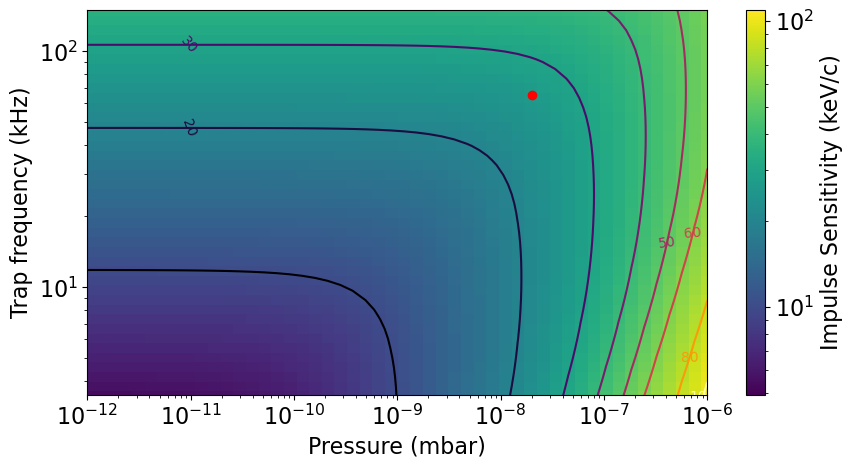

<Figure size 640x480 with 0 Axes>

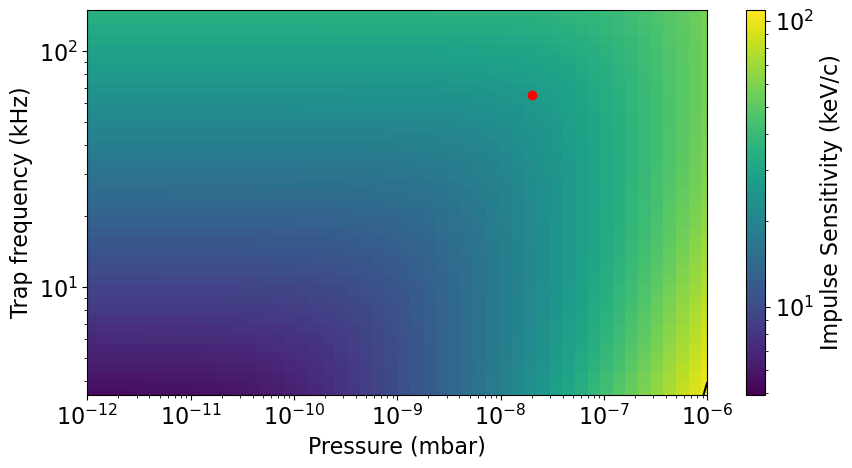

In [29]:
X, Y = np.meshgrid(press, wzs/2/np.pi/1000)
plt.rcParams['font.size'] = 16
data_sh = res
fig=plt.figure(figsize = (10, 5))
ax=fig.add_subplot(111)
pc = ax.pcolormesh(X, Y, data_sh,  norm=colors.LogNorm(vmin=data_sh.min(), vmax=data_sh.max()))
CS = ax.contour(X, Y, data_sh, levels = [10, 20, 30, 40, 50, 60, 80, 100], cmap = 'inferno')
ax.clabel(CS, CS.levels, inline=False, fontsize=10)
ax.scatter([2e-8], [65], marker = 'o', color = 'r')
cbar = fig.colorbar(pc)
cbar.set_label('Impulse Sensitivity (keV/c)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Trap frequency (kHz)')
plt.xlabel('Pressure (mbar)')
plt.ylim(3.5*10**0, 1.5*10**2)
plt.xlim(10**(-12), 10**(-6))

plt.figure()
X, Y = np.meshgrid(press, wzs/2/np.pi/1000)
plt.rcParams['font.size'] = 16
data_sh = res
fig=plt.figure(figsize = (10, 5))
ax=fig.add_subplot(111)
pc = ax.pcolormesh(X, Y, data_sh,  norm=colors.LogNorm(vmin=data_sh.min(), vmax=data_sh.max()))
CS = ax.contour(X, Y, data_sh, levels = [100], cmap = 'inferno')
ax.scatter([2e-8], [65], marker = 'o', color = 'r')
cbar = fig.colorbar(pc)
cbar.set_label('Impulse Sensitivity (keV/c)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Trap frequency (kHz)')
plt.xlabel('Pressure (mbar)')
plt.ylim(3.5*10**0, 1.5*10**2)
plt.xlim(10**(-12), 10**(-6))

Text(0.5, 0, 'Trap frequency (Hz)')

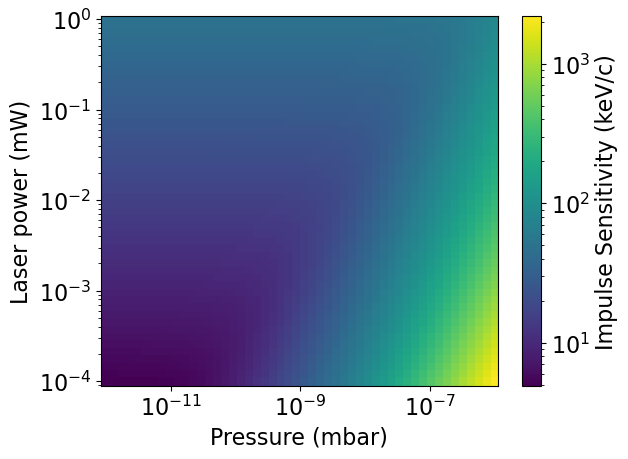

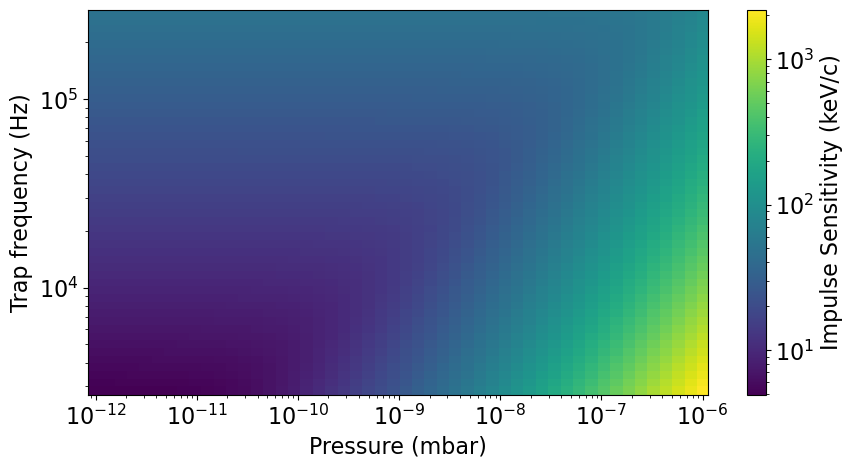

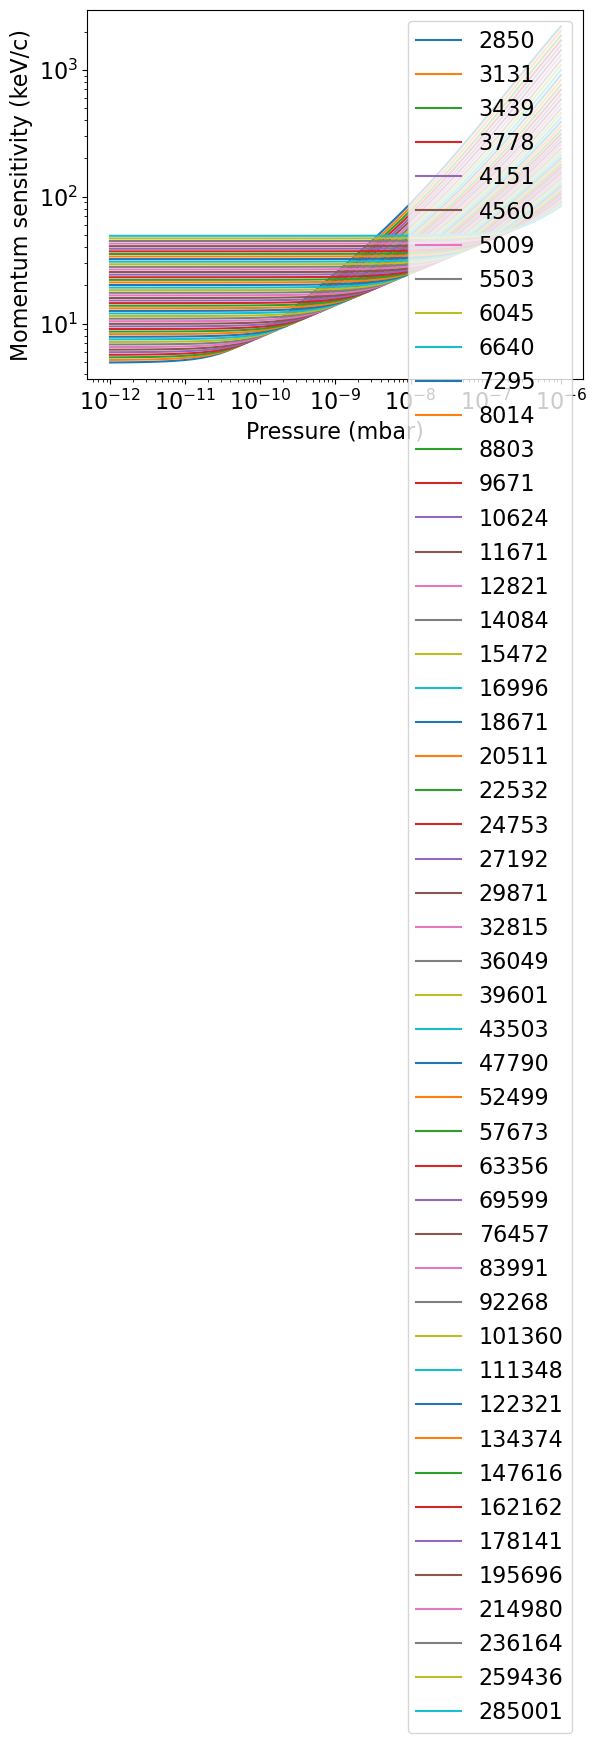

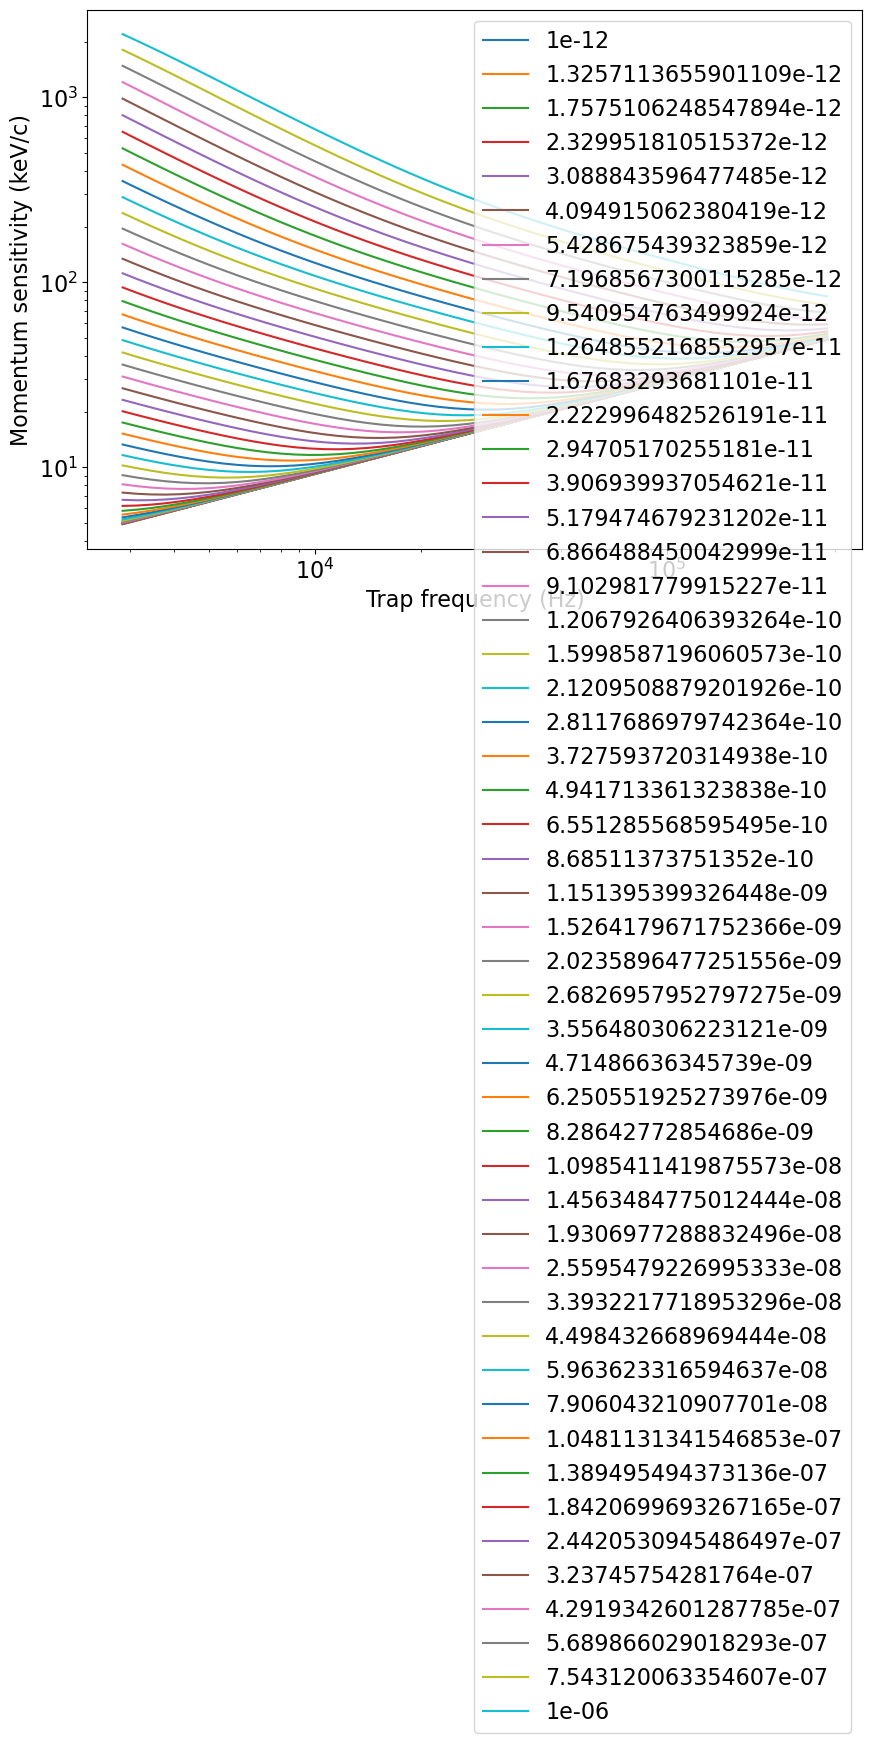

In [414]:
X, Y = np.meshgrid(press, pow)
data_sh = res
fig=plt.figure()
ax=fig.add_subplot(111)
pc = ax.pcolormesh(X, Y, data_sh,  norm=colors.LogNorm(vmin=data_sh.min(), vmax=data_sh.max()))
cbar = fig.colorbar(pc)
cbar.set_label('Impulse Sensitivity (keV/c)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Laser power (mW)')
plt.xlabel('Pressure (mbar)')

X, Y = np.meshgrid(press, wzs/2/np.pi)
plt.rcParams['font.size'] = 16
data_sh = res
fig=plt.figure(figsize = (10, 5))
ax=fig.add_subplot(111)
pc = ax.pcolormesh(X, Y, data_sh,  norm=colors.LogNorm(vmin=data_sh.min(), vmax=data_sh.max()))
cbar = fig.colorbar(pc)
cbar.set_label('Impulse Sensitivity (keV/c)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Trap frequency (Hz)')
plt.xlabel('Pressure (mbar)')

plt.figure()
for n, re in enumerate(res):
    plt.plot(press, re, label = str(round(wzs[n]/2/np.pi)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('Momentum sensitivity (keV/c)')
plt.xlabel('Pressure (mbar)')


plt.figure(figsize = (10, 7))
for n, re in enumerate(np.transpose(res)):
    plt.plot(wzs/2/np.pi, re, label = str(press[n]))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('Momentum sensitivity (keV/c)')
plt.xlabel('Trap frequency (Hz)')

Text(0.5, 0, 'Collection efficiency')

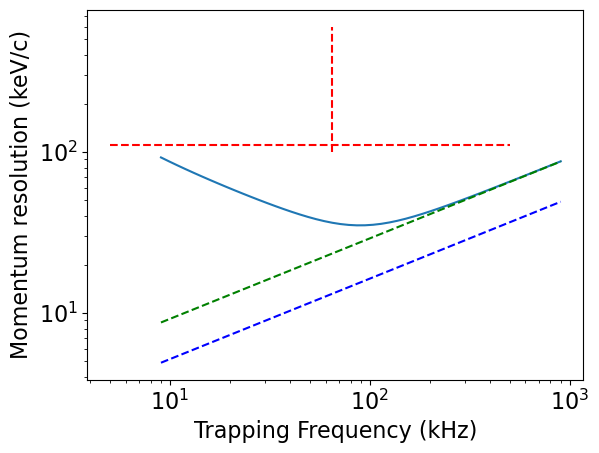

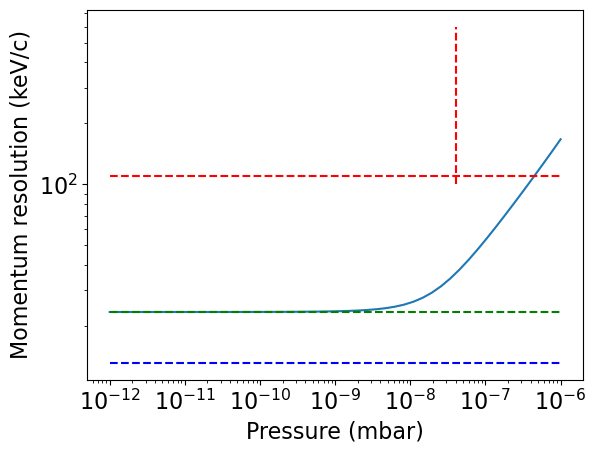

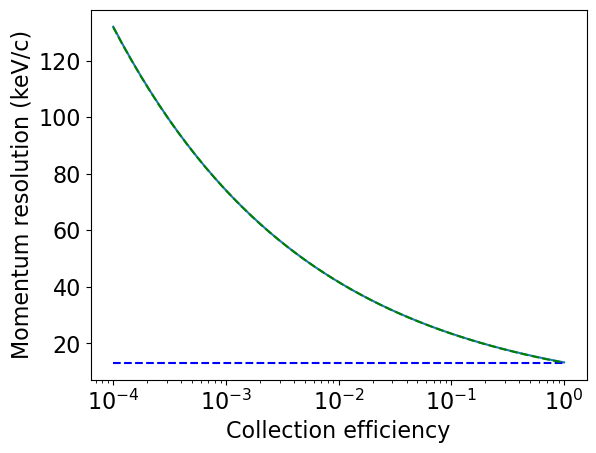

In [438]:
# Let's plot the one we actually care about. Currently at 65000 Hz and 4x10^(-8) mbar

press = np.logspace(-12, -6, 50)
pow = np.logspace(-3, 1, 50)

wzs = []
for P0 in pow:
    Gu, wz = calc_Gstar(P0)
    wzs.append(wz)

wzs = np.array(wzs)

P0 = 1000

P = 4*10**(-8)

N=N0*P/P0 # Number density of air at pressure P
y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
Ggas = 2*kb*T*y/10**(-34)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((50))
for n, wz in enumerate(wzs):
    eff = np.sqrt(1/eff_func(x, 0.1, Ggas/wz**2, Gu))
    res[n] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wzs)/SI2eV/10**3

plt.figure()
plt.plot(wzs/2/np.pi/1000, res)
plt.plot([65, 65], [100, 600], 'r--')
plt.plot([5, 500], [110, 110], 'r--')
plt.plot(wzs/2/np.pi/1000, SQL, 'b--')
plt.plot(wzs/2/np.pi/1000, (0.1)**(-1/4)*SQL, 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Trapping Frequency (kHz)')

Ggass = []
for P in press:
    N=N0*P/P0 # Number density of air at pressure P
    y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
    Ggas = 2*kb*T*y/10**(-34)
    Ggass.append(Ggas)


wz = 2*np.pi*65000
Ggass = np.array(Ggass)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((50))
for k, Ggas in enumerate(Ggass):
    eff = np.sqrt(1/eff_func(x, 0.1, Ggas/wz**2, Gu))
    res[k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wz)/SI2eV/10**3

plt.figure()
plt.plot(press, res)
plt.plot([4e-8, 4e-8], [100, 600], 'r--')
plt.plot([10**(-12), 10**(-6)], [110, 110], 'r--')
plt.plot([10**(-12), 10**(-6)], [SQL, SQL], 'b--')
plt.plot([10**(-12), 10**(-6)], [(0.1)**(-1/4)*SQL, (0.1)**(-1/4)*SQL], 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Pressure (mbar)')

wz = 2*np.pi*65000
P = 4*10**(-11)
N=N0*P/P0 # Number density of air at pressure P
y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
Ggas = 2*kb*T*y/10**(-34)

x = np.linspace(0, 10, 10**6)
etas = np.logspace(-4, 0, 50)
res = np.zeros((50))
for k, eta in enumerate(etas):
    eff = np.sqrt(1/eff_func(x, eta, Ggas/wz**2, Gu))
    res[k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wz)/SI2eV/10**3

plt.figure()
plt.plot(etas, res)
plt.plot([1e-4, 1], [SQL, SQL], 'b--')
plt.plot(etas, (etas)**(-1/4)*SQL, 'g--')
plt.xscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Collection efficiency')

In [469]:
# For a bigger particle but diffraction limited lens
# Collection efficiency of 0.1 (very reasonable with our 0.77 NA lens I think)

T = 293 # Environmental temperature
R = (0.083)*10**(-6) # Particle Radius
p = 2200 # Particle Denisty
M = 4/3*np.pi*R**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
Pamb = 1000 # Ambient pressure

def calc_Gstar(P0):
    c = 3*10**8
    rho = 2200
    eps = 1.45**2
    NA = 0.77
    wav = 1064*10**(-9)
    wz = np.sqrt(24/np.pi/c/rho*(eps-1)/(eps+2)*(np.pi*NA/wav)**4*NA**2*P0)/(2.8*1.4)
    omega_rayleigh= 1.4 * wav / (np.pi * NA) 
    k = 2*np.pi/wav
    V = (4/3) * np.pi * (166e-9/2)**3
    Psc = 9*(1/3) * (k**4 * V**2 * ((eps-1)/(eps+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * P0
    A = calc_geometric_factor(NA)
    G = (A**2+0.4)*k/2/V/rho/wz/c*Psc
    return G/wz, wz

press = np.logspace(-10, -6, 20)
pow = np.logspace(-3, 0, 20)

wzs = []
for P0 in pow:
    Gu, wz = calc_Gstar(P0)
    wzs.append(wz)

P0 = 1000
Ggass = []
for P in press:
    N=N0*P/P0 # Number density of air at pressure P
    y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
    Ggas = 2*kb*T*y/10**(-34)
    Ggass.append(Ggas)

wzs = np.array(wzs)
Ggass = np.array(Ggass)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((20, 20))
for n, wz in enumerate(wzs):
    for k, Ggas in enumerate(Ggass):
        eff = np.sqrt(1/eff_func(x, 0.1, Ggas/wz**2, Gu))
        res[n][k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

4.0385189872791095e-07
5.809207186099241e-07
8.356253427884342e-07
1.2020051809843633e-06
1.7290242183081494e-06
2.4871146936720212e-06
3.57758985327112e-06
5.14618372477692e-06
7.40252740401315e-06
1.064816471734908e-05
1.531685134813942e-05
2.2032523110649875e-05
3.169268040720967e-05
4.558833259128733e-05
6.557653192315808e-05
9.43285550191591e-05
0.0001356868994296461
0.00019517880532667376
0.0002807549307182734
0.00040385189872791093


Text(0.5, 0, 'Trap frequency (Hz)')

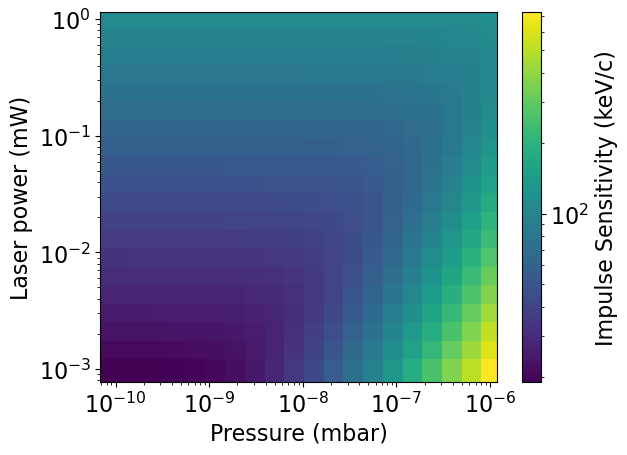

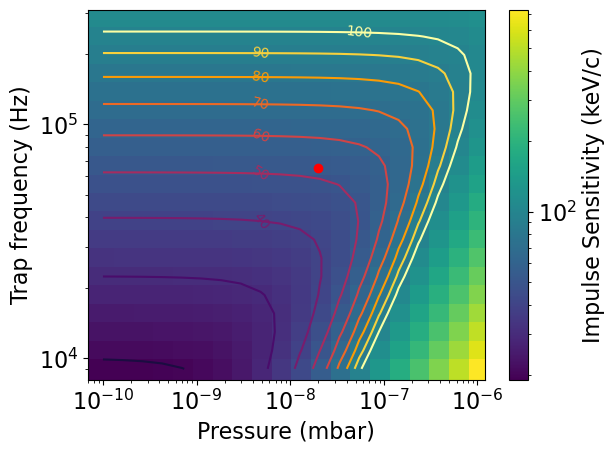

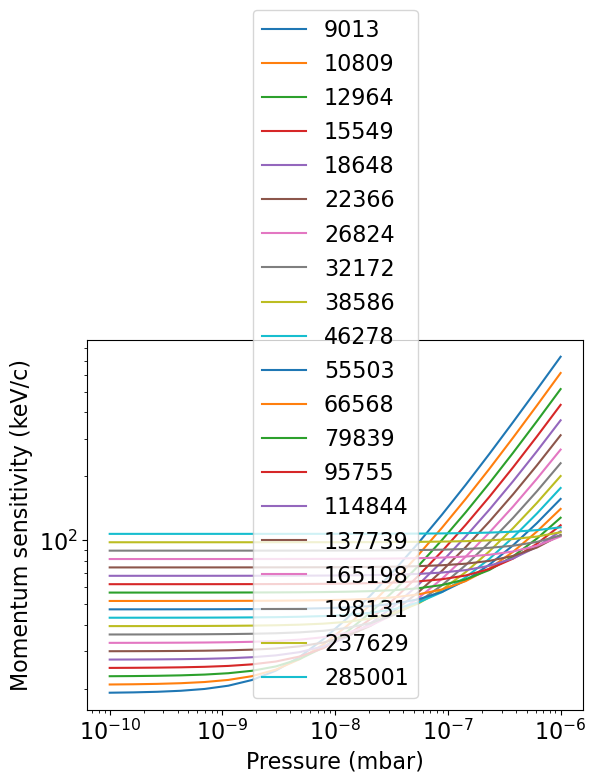

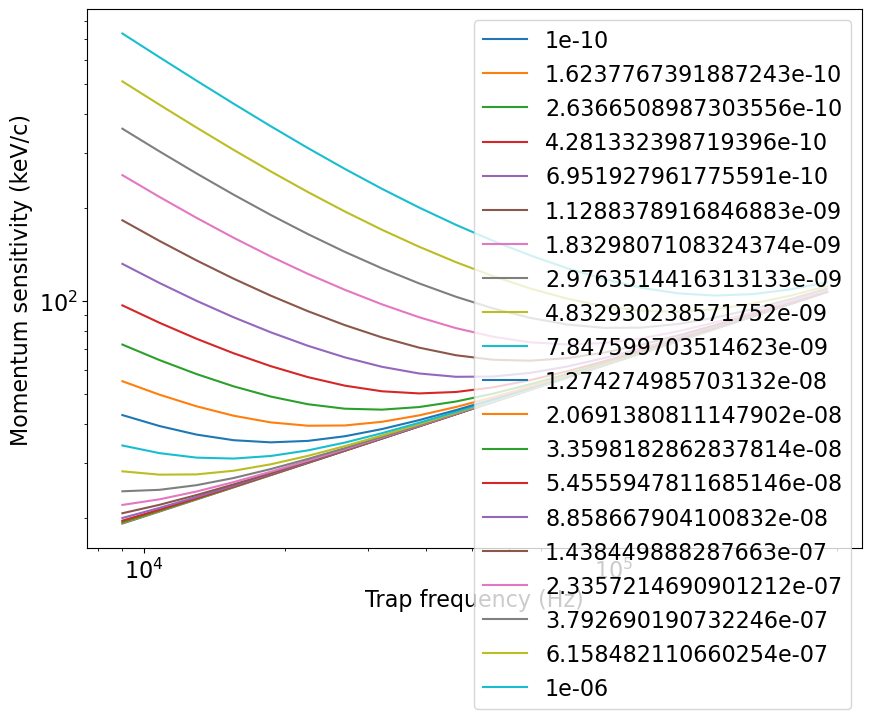

In [470]:
X, Y = np.meshgrid(press, pow)
data_sh = res
fig=plt.figure()
ax=fig.add_subplot(111)
pc = ax.pcolormesh(X, Y, data_sh,  norm=colors.LogNorm(vmin=data_sh.min(), vmax=data_sh.max()))
cbar = fig.colorbar(pc)
cbar.set_label('Impulse Sensitivity (keV/c)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Laser power (mW)')
plt.xlabel('Pressure (mbar)')

X, Y = np.meshgrid(press, wzs/2/np.pi)
data_sh = res
fig=plt.figure()
ax=fig.add_subplot(111)
pc = ax.pcolormesh(X, Y, data_sh,  norm=colors.LogNorm(vmin=data_sh.min(), vmax=data_sh.max()))
CS = ax.contour(X, Y, data_sh, levels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], cmap = 'inferno')
ax.clabel(CS, CS.levels, inline=False, fontsize=10)
ax.scatter([2e-8], [65000], marker = 'o', color = 'r')
cbar = fig.colorbar(pc)
cbar.set_label('Impulse Sensitivity (keV/c)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Trap frequency (Hz)')
plt.xlabel('Pressure (mbar)')

plt.figure()
for n, re in enumerate(res):
    plt.plot(press, re, label = str(round(wzs[n]/2/np.pi)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('Momentum sensitivity (keV/c)')
plt.xlabel('Pressure (mbar)')


plt.figure(figsize = (10, 7))
for n, re in enumerate(np.transpose(res)):
    plt.plot(wzs/2/np.pi, re, label = str(press[n]))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('Momentum sensitivity (keV/c)')
plt.xlabel('Trap frequency (Hz)')

4.0385189872791095e-07
4.873654992930625e-07
5.881490978483798e-07
7.097740028820846e-07
8.565500431952175e-07
1.0336782884672877e-06
1.24743535131098e-06
1.505395801635425e-06
1.816700574662974e-06
2.192380883748517e-06
2.6457491159860576e-06
3.1928705621499847e-06
3.853132696916559e-06
4.649932182045668e-06
5.611503936764688e-06
6.771921653806245e-06
8.172305214799488e-06
9.862277790278434e-06
1.190172425724871e-05
1.4362913244566325e-05
1.733305800168378e-05
2.0917406836206616e-05
2.5242972631192922e-05
3.0463033599183612e-05
3.676256475904339e-05
4.43647926022403e-05
5.353910521587369e-05
6.461059816093107e-05
7.797159436791658e-05
9.409554626211666e-05
0.00011355381274605979
0.00013703590553848136
0.00016537392230718558
0.00019957203239397172
0.00024084205997047881
0.00029064642552878943
0.0003507499673562698
0.00042328247931003126
0.0005108141809429147
0.0006164467942961154
0.0007439234547022582
0.0008977613503336705
0.0010834117906330998
0.0013074533757179022
0.00157782511179541

Text(0.5, 0, 'Collection efficiency')

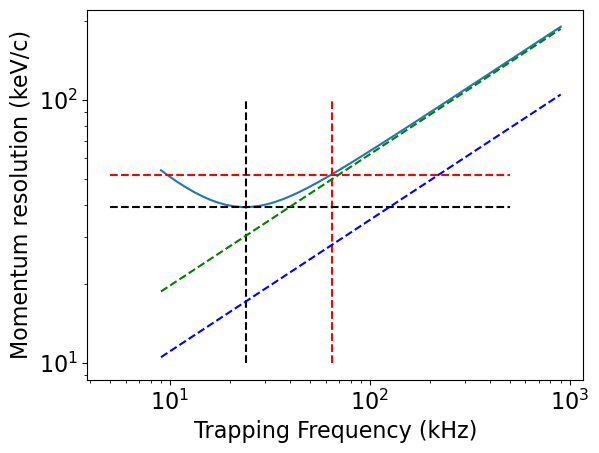

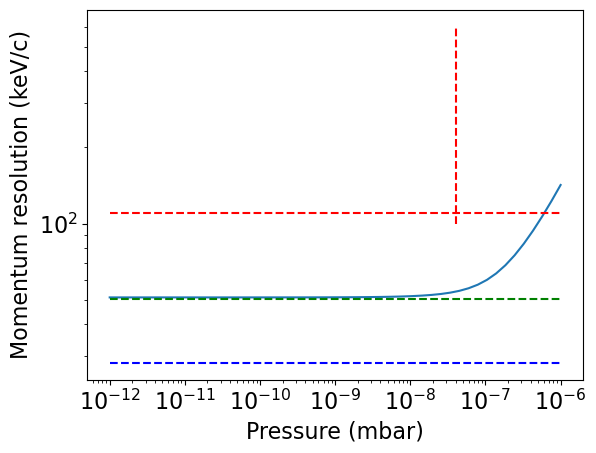

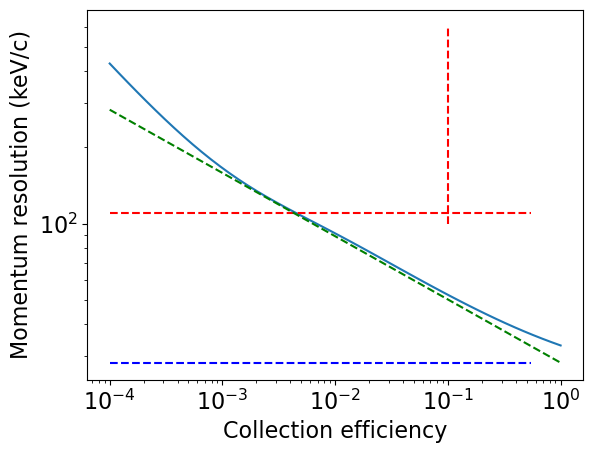

In [474]:
# Let's plot the one we actually care about. Currently at 65000 Hz and 2x10^(-8) mbar

press = np.logspace(-12, -6, 50)
pow = np.logspace(-3, 1, 50)

wzs = []
for P0 in pow:
    Gu, wz = calc_Gstar(P0)
    wzs.append(wz)

wzs = np.array(wzs)

P0 = 1000

P = 2*10**(-8)

N=N0*P/P0 # Number density of air at pressure P
y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
Ggas = 2*kb*T*y/10**(-34)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((50))
for n, wz in enumerate(wzs):
    eff = np.sqrt(1/eff_func(x, 0.1, Ggas/wz**2, Gu))
    res[n] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wzs)/SI2eV/10**3

plt.figure()
plt.plot(wzs/2/np.pi/1000, res)
plt.plot([65, 65], [10, 100], 'r--')
plt.plot([5, 500], [52, 52], 'r--')
plt.plot([24, 24], [10, 100], 'k--')
plt.plot([5, 500], [39, 39], 'k--')
plt.plot(wzs/2/np.pi/1000, SQL, 'b--')
plt.plot(wzs/2/np.pi/1000, (0.1)**(-1/4)*SQL, 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Trapping Frequency (kHz)')

Ggass = []
for P in press:
    N=N0*P/P0 # Number density of air at pressure P
    y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
    Ggas = 2*kb*T*y/10**(-34)
    Ggass.append(Ggas)


wz = 2*np.pi*65000
Ggass = np.array(Ggass)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((50))
for k, Ggas in enumerate(Ggass):
    eff = np.sqrt(1/eff_func(x, 0.1, Ggas/wz**2, Gu))
    res[k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wz)/SI2eV/10**3

plt.figure()
plt.plot(press, res)
plt.plot([4e-8, 4e-8], [100, 600], 'r--')
plt.plot([10**(-12), 10**(-6)], [110, 110], 'r--')
plt.plot([10**(-12), 10**(-6)], [SQL, SQL], 'b--')
plt.plot([10**(-12), 10**(-6)], [(0.1)**(-1/4)*SQL, (0.1)**(-1/4)*SQL], 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Pressure (mbar)')

wz = 2*np.pi*65000
P = 2*10**(-8)
N=N0*P/P0 # Number density of air at pressure P
y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
Ggas = 2*kb*T*y/10**(-34)

### Not sure if this next one is converging properly for low eta ###

x = np.linspace(0, 100000, 10**6)
etas = np.logspace(-4, 0, 50)
res = np.zeros((50))
for k, eta in enumerate(etas):
    eff = np.sqrt(1/eff_func(x, eta, Ggas/wz**2, Gu))
    res[k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wz)/SI2eV/10**3

plt.figure()
plt.plot(etas, res)
plt.plot([0.1, 0.1], [100, 600], 'r--')
plt.plot([1e-4, 0.55], [110, 110], 'r--')
plt.plot([1e-4, 0.55], [SQL, SQL], 'b--')
plt.plot(etas, (etas)**(-1/4)*SQL, 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Collection efficiency')

In [543]:
# Assuming we have to scatter four times as much power to get the correct trapping frequency due to not diffraction limited lens
# Also with a bigger sphere for the actual set up
# Collection efficiency of 0.1 (very reasonable with our 0.77 NA lens I think)

c = 3*10**8
rho = 2200
eps = 1.45**2
NA = 0.77
wav = 1064*10**(-9)
P0 = 600*10**(-3)
wz = np.sqrt(24/np.pi/c/rho*(eps-1)/(eps+2)*(np.pi*NA/wav)**4*NA**2*P0)/(2.8*1.4)/2
print(wz/2/np.pi)

omega_rayleigh= 1.4 * wav / (np.pi * NA**2) *np.sqrt(2)
k = 2*np.pi/wav
V = (4/3) * np.pi * (166e-9/2)**3
Psc = (1/3) * (k**4 * V**2 * ((eps-1)/(eps+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * P0
print(Psc)

def calc_geometric_factor(na):
    thetamax = np.arcsin(na)
    C = 2 * ( 8 / 15 - (np.cos(thetamax)**(3/2) ) / 3 - (np.cos(thetamax)**(5/2) ) / 5 )
    D = 2 * ( 12 / 35 - (np.cos(thetamax)**(5/2) ) / 5 - (np.cos(thetamax)**(7/2) ) / 7 )
    return D / C

A = calc_geometric_factor(NA)
print(A)
G = (A**2+0.4)*k/2/V/rho/wz/c*Psc
print(G)
print(G/wz)

def calc_Gstar2(P0):
    c = 3*10**8
    rho = 2200
    eps = 1.45**2
    NA = 0.77
    wav = 1064*10**(-9)
    wz = np.sqrt(24/np.pi/c/rho*(eps-1)/(eps+2)*(np.pi*NA/wav)**4*NA**2*P0)/(2.8*1.4)/2
    omega_rayleigh= 1.4 * wav / (np.pi * NA)*np.sqrt(2) 
    k = 2*np.pi/wav
    V = (4/3) * np.pi * (166e-9/2)**3
    Psc = 9*(1/3) * (k**4 * V**2 * ((eps-1)/(eps+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * P0
    A = calc_geometric_factor(NA)
    G = (A**2+0.4)*k/2/V/rho/wz/c*Psc
    return G/wz, wz

110380.42961980577
7.981459691859275e-06
0.8316709910861878
23466.36466315399
0.03383559880498777


In [544]:
T = 293 # Environmental temperature
R = (0.083)*10**(-6) # Particle Radius
p = 2200 # Particle Denisty
M = 4/3*np.pi*R**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
Pamb = 1000 # Ambient pressure


wzs = []
for P0 in np.logspace(-3, 0, 20)*4:
    Gu, wz = calc_Gstar2(P0)
    wzs.append(wz)

P0 = 1000
Ggass = []
for P in np.logspace(-10, -6, 20):
    N=N0*P/P0 # Number density of air at pressure P
    y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
    Ggas = 2*kb*T*y/10**(-34)
    Ggass.append(Ggas)

Gus = np.array(Gus)
wzs = np.array(wzs)
Ggass = np.array(Ggass)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((20, 20))
for n, wz in enumerate(wzs):
    for k, Ggas in enumerate(Ggass):
        eff = np.sqrt(1/eff_func(x, 0.1, Ggas/wz**2, Gu))
        res[n][k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

Text(0.5, 0, 'Trap frequency (Hz)')

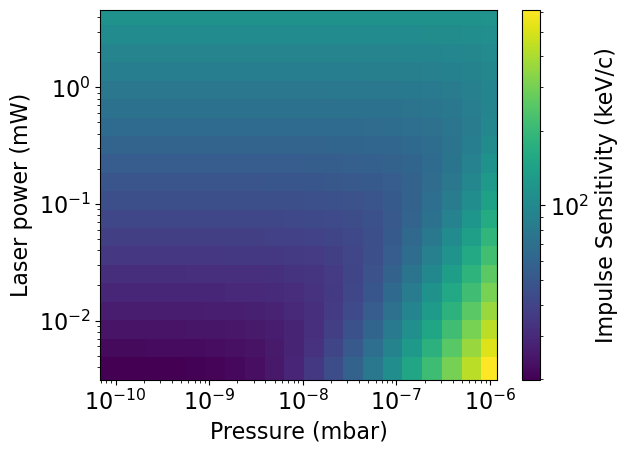

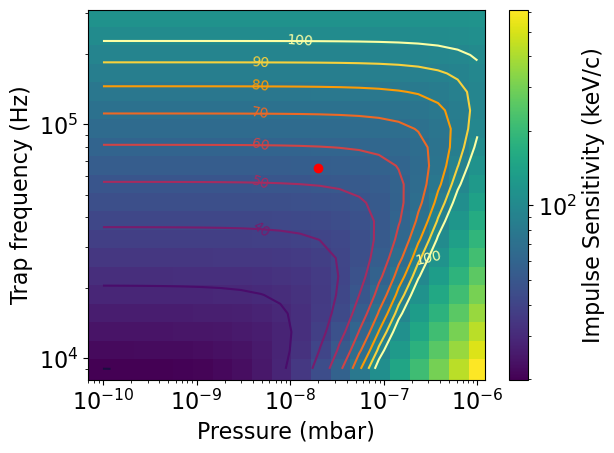

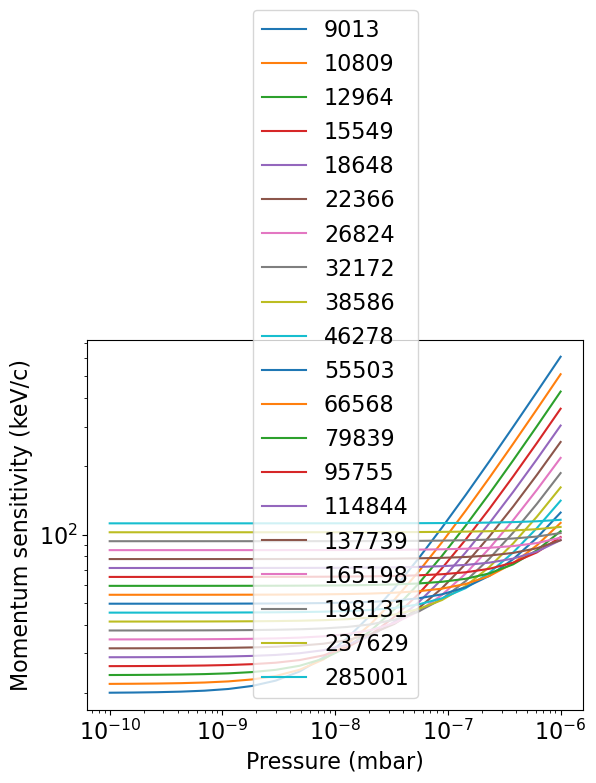

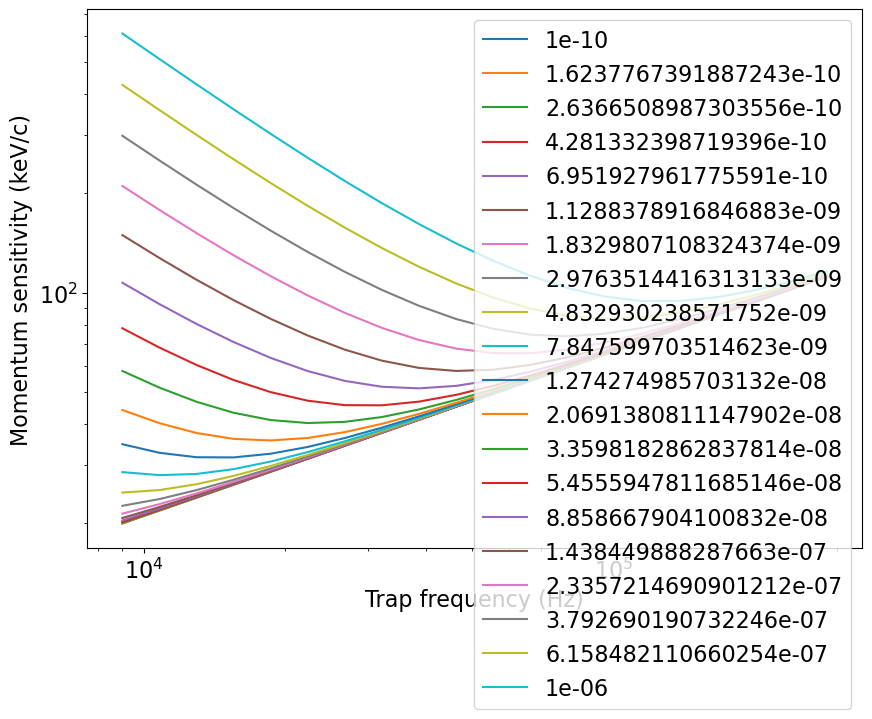

In [545]:
X, Y = np.meshgrid(np.logspace(-10, -6, 20), np.logspace(-3, 0, 20)*4)
data_sh = res
fig=plt.figure()
ax=fig.add_subplot(111)
pc = ax.pcolormesh(X, Y, data_sh,  norm=colors.LogNorm(vmin=data_sh.min(), vmax=data_sh.max()))
cbar = fig.colorbar(pc)
cbar.set_label('Impulse Sensitivity (keV/c)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Laser power (mW)')
plt.xlabel('Pressure (mbar)')

X, Y = np.meshgrid(np.logspace(-10, -6, 20), wzs/2/np.pi)
data_sh = res
fig=plt.figure()
ax=fig.add_subplot(111)
pc = ax.pcolormesh(X, Y, data_sh,  norm=colors.LogNorm(vmin=data_sh.min(), vmax=data_sh.max()))
CS = ax.contour(X, Y, data_sh, levels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], cmap = 'inferno')
ax.clabel(CS, CS.levels, inline=False, fontsize=10)
ax.scatter([2e-8], [65000], marker = 'o', color = 'r')
cbar = fig.colorbar(pc)
cbar.set_label('Impulse Sensitivity (keV/c)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Trap frequency (Hz)')
plt.xlabel('Pressure (mbar)')

plt.figure()
for n, re in enumerate(res):
    plt.plot(np.logspace(-10, -6, 20), re, label = str(round(wzs[n]/2/np.pi)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('Momentum sensitivity (keV/c)')
plt.xlabel('Pressure (mbar)')


press = np.logspace(-10, -6, 20)
plt.figure(figsize = (10, 7))
for n, re in enumerate(np.transpose(res)):
    plt.plot(wzs/2/np.pi, re, label = str(press[n]))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('Momentum sensitivity (keV/c)')
plt.xlabel('Trap frequency (Hz)')

Text(0.5, 0, 'Collection efficiency')

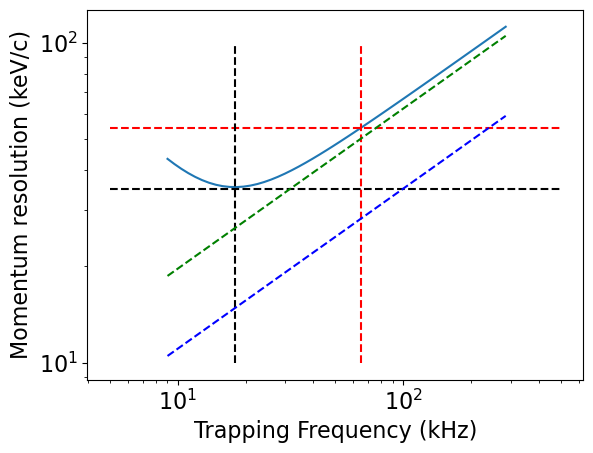

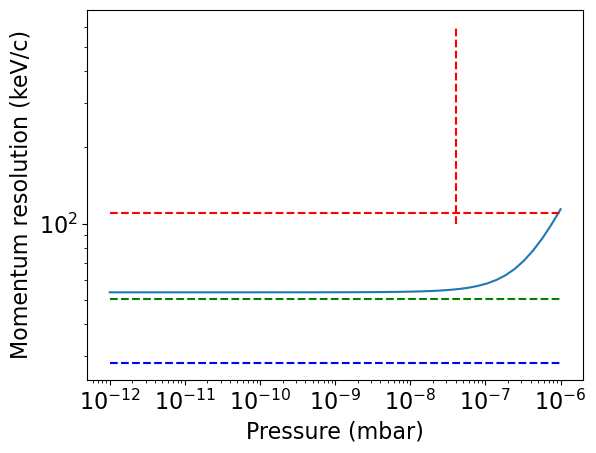

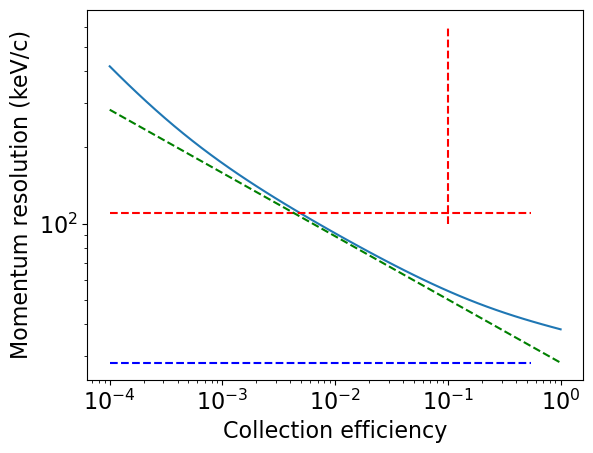

In [522]:
# Let's plot the one we actually care about. Currently at 65000 Hz and 2x10^(-8) mbar

press = np.logspace(-12, -6, 50)
pow = np.logspace(-3, 0, 50)*4

wzs = []
for P0 in pow:
    Gu, wz = calc_Gstar2(P0)
    wzs.append(wz)

wzs = np.array(wzs)

P0 = 1000

P = 2*10**(-8)

N=N0*P/P0 # Number density of air at pressure P
y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
Ggas = 2*kb*T*y/10**(-34)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((50))
for n, wz in enumerate(wzs):
    eff = np.sqrt(1/eff_func(x, 0.1, Ggas/wz**2, Gu))
    res[n] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wzs)/SI2eV/10**3

plt.figure()
plt.plot(wzs/2/np.pi/1000, res)
plt.plot([65, 65], [10, 100], 'r--')
plt.plot([5, 500], [54, 54], 'r--')
plt.plot([18, 18], [10, 100], 'k--')
plt.plot([5, 500], [35, 35], 'k--')
plt.plot(wzs/2/np.pi/1000, SQL, 'b--')
plt.plot(wzs/2/np.pi/1000, (0.1)**(-1/4)*SQL, 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Trapping Frequency (kHz)')

Ggass = []
for P in press:
    N=N0*P/P0 # Number density of air at pressure P
    y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
    Ggas = 2*kb*T*y/10**(-34)
    Ggass.append(Ggas)


wz = 2*np.pi*65000
Ggass = np.array(Ggass)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((50))
for k, Ggas in enumerate(Ggass):
    eff = np.sqrt(1/eff_func(x, 0.1, Ggas/wz**2, Gu))
    res[k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wz)/SI2eV/10**3

plt.figure()
plt.plot(press, res)
plt.plot([4e-8, 4e-8], [100, 600], 'r--')
plt.plot([10**(-12), 10**(-6)], [110, 110], 'r--')
plt.plot([10**(-12), 10**(-6)], [SQL, SQL], 'b--')
plt.plot([10**(-12), 10**(-6)], [(0.1)**(-1/4)*SQL, (0.1)**(-1/4)*SQL], 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Pressure (mbar)')

wz = 2*np.pi*65000
P = 2*10**(-8)
N=N0*P/P0 # Number density of air at pressure P
y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
Ggas = 2*kb*T*y/10**(-34)

x = np.linspace(0, 10000, 10**6)
etas = np.logspace(-4, 0, 50)
res = np.zeros((50))
for k, eta in enumerate(etas):
    eff = np.sqrt(1/eff_func(x, eta, Ggas/wz**2, Gu))
    res[k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wz)/SI2eV/10**3

plt.figure()
plt.plot(etas, res)
plt.plot([0.1, 0.1], [100, 600], 'r--')
plt.plot([1e-4, 0.55], [110, 110], 'r--')
plt.plot([1e-4, 0.55], [SQL, SQL], 'b--')
plt.plot(etas, (etas)**(-1/4)*SQL, 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Collection efficiency')

In [526]:
### 0.9 NA

In [540]:
# For a bigger particle but diffraction limited lens
# Collection efficiency of 0.3 (reasonable with a 0.9 NA lens I think)

T = 293 # Environmental temperature
R = (0.083)*10**(-6) # Particle Radius
p = 2200 # Particle Denisty
M = 4/3*np.pi*R**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
Pamb = 1000 # Ambient pressure

def calc_Gstar(P0):
    c = 3*10**8
    rho = 2200
    eps = 1.45**2
    NA = 0.9
    wav = 1064*10**(-9)
    wz = np.sqrt(24/np.pi/c/rho*(eps-1)/(eps+2)*(np.pi*NA/wav)**4*NA**2*P0)/(2.4*1.39)
    omega_rayleigh= 1.39 * wav / (np.pi * NA) 
    k = 2*np.pi/wav
    V = (4/3) * np.pi * (166e-9/2)**3
    Psc = 9*(1/3) * (k**4 * V**2 * ((eps-1)/(eps+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * P0
    A = calc_geometric_factor(NA)
    G = (A**2+0.4)*k/2/V/rho/wz/c*Psc
    return G/wz, wz

press = np.logspace(-10, -6, 20)
pow = np.logspace(-3, 0, 20)

wzs = []
for P0 in pow:
    Gu, wz = calc_Gstar(P0)
    wzs.append(wz)

P0 = 1000
Ggass = []
for P in press:
    N=N0*P/P0 # Number density of air at pressure P
    y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
    Ggas = 2*kb*T*y/10**(-34)
    Ggass.append(Ggas)

wzs = np.array(wzs)
Ggass = np.array(Ggass)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((20, 20))
for n, wz in enumerate(wzs):
    for k, Ggas in enumerate(Ggass):
        eff = np.sqrt(1/eff_func(x, 0.3, Ggas/wz**2, Gu))
        res[n][k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

Text(0.5, 0, 'Trap frequency (Hz)')

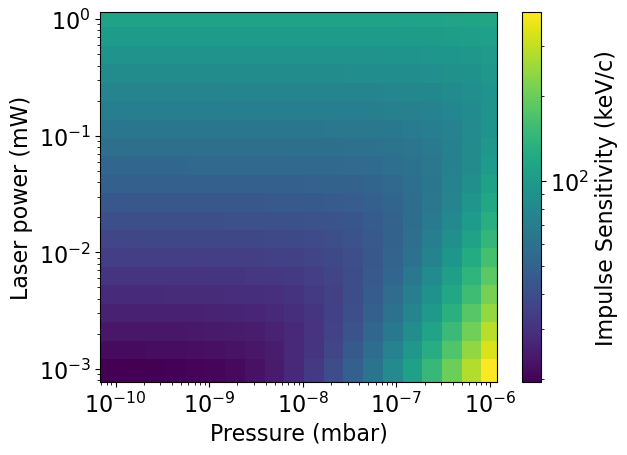

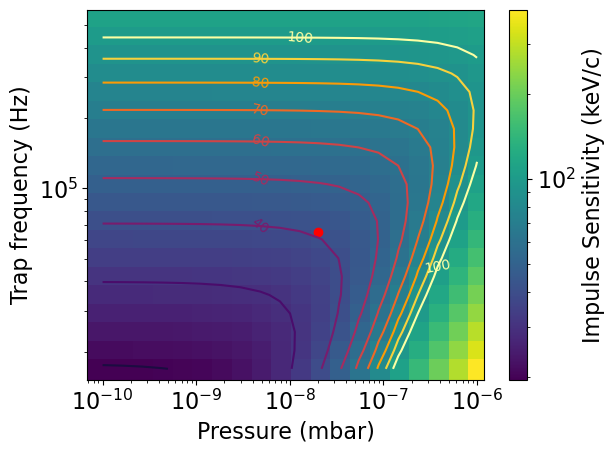

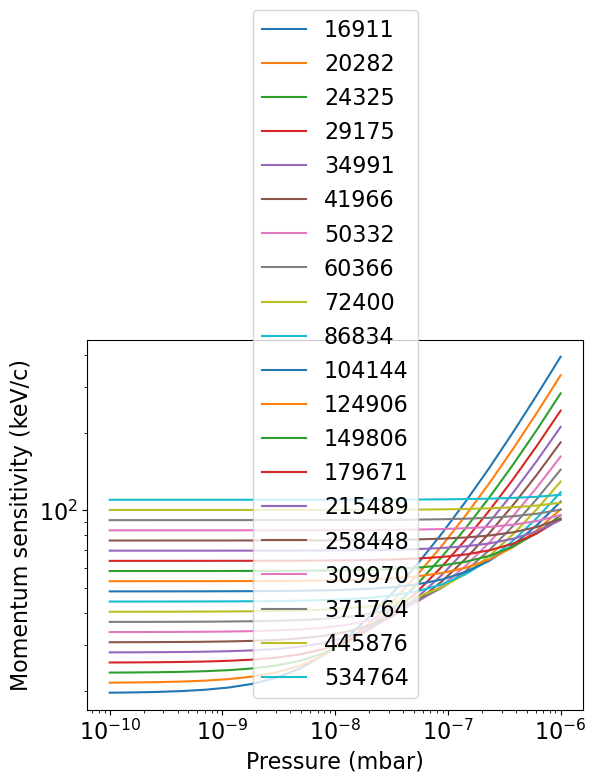

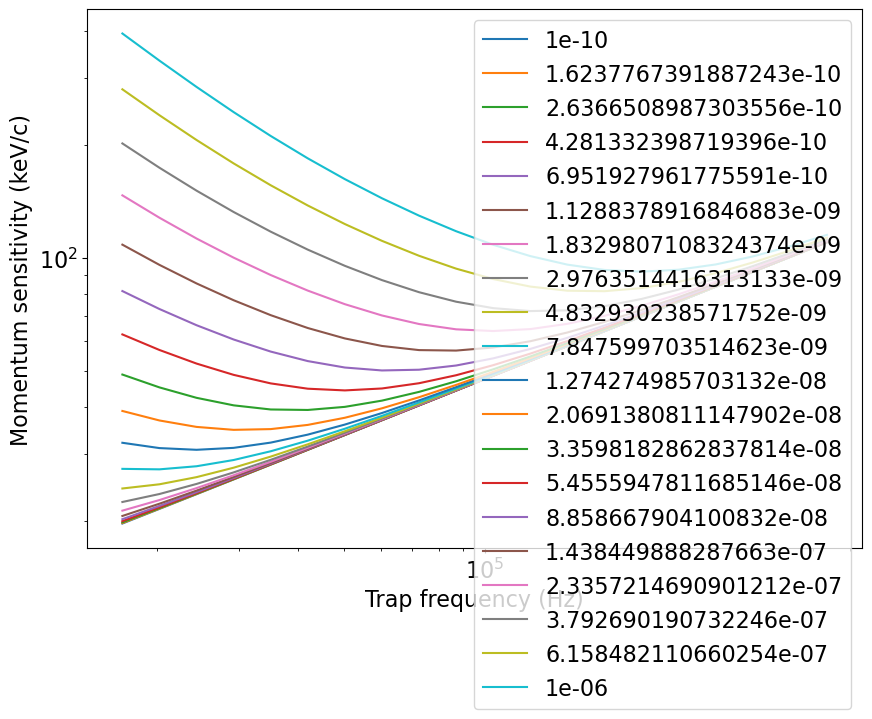

In [541]:
X, Y = np.meshgrid(press, pow)
data_sh = res
fig=plt.figure()
ax=fig.add_subplot(111)
pc = ax.pcolormesh(X, Y, data_sh,  norm=colors.LogNorm(vmin=data_sh.min(), vmax=data_sh.max()))
cbar = fig.colorbar(pc)
cbar.set_label('Impulse Sensitivity (keV/c)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Laser power (mW)')
plt.xlabel('Pressure (mbar)')

X, Y = np.meshgrid(press, wzs/2/np.pi)
data_sh = res
fig=plt.figure()
ax=fig.add_subplot(111)
pc = ax.pcolormesh(X, Y, data_sh,  norm=colors.LogNorm(vmin=data_sh.min(), vmax=data_sh.max()))
CS = ax.contour(X, Y, data_sh, levels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], cmap = 'inferno')
ax.clabel(CS, CS.levels, inline=False, fontsize=10)
ax.scatter([2e-8], [65000], marker = 'o', color = 'r')
cbar = fig.colorbar(pc)
cbar.set_label('Impulse Sensitivity (keV/c)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Trap frequency (Hz)')
plt.xlabel('Pressure (mbar)')

plt.figure()
for n, re in enumerate(res):
    plt.plot(press, re, label = str(round(wzs[n]/2/np.pi)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('Momentum sensitivity (keV/c)')
plt.xlabel('Pressure (mbar)')


plt.figure(figsize = (10, 7))
for n, re in enumerate(np.transpose(res)):
    plt.plot(wzs/2/np.pi, re, label = str(press[n]))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('Momentum sensitivity (keV/c)')
plt.xlabel('Trap frequency (Hz)')

Text(0.5, 0, 'Collection efficiency')

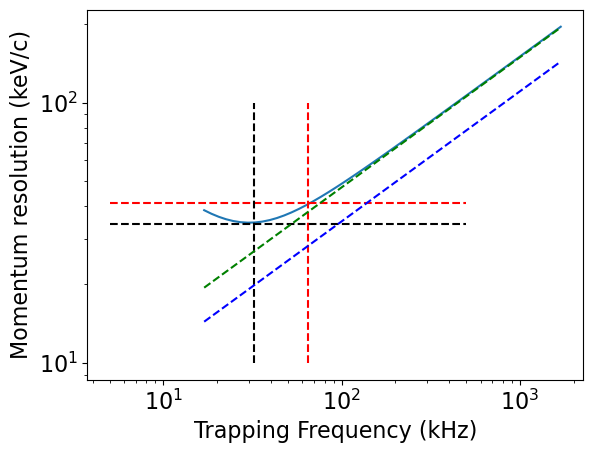

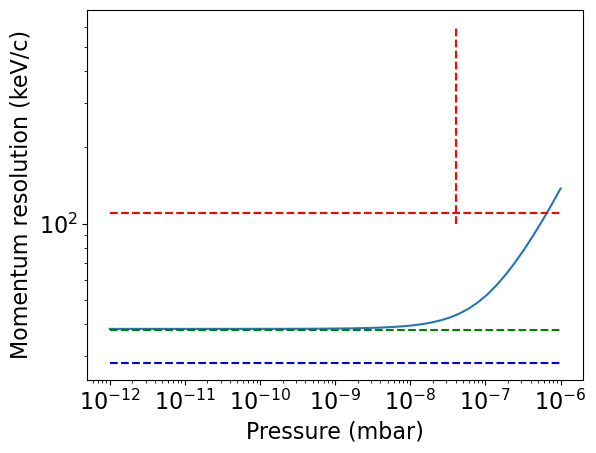

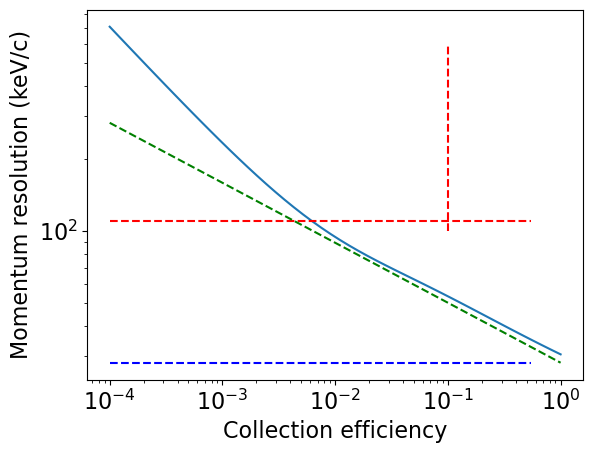

In [548]:
# Let's plot the one we actually care about. Currently at 65000 Hz and 2x10^(-8) mbar

press = np.logspace(-12, -6, 50)
pow = np.logspace(-3, 1, 50)

wzs = []
for P0 in pow:
    Gu, wz = calc_Gstar(P0)
    wzs.append(wz)

wzs = np.array(wzs)

P0 = 1000

P = 2*10**(-8)

N=N0*P/P0 # Number density of air at pressure P
y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
Ggas = 2*kb*T*y/10**(-34)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((50))
for n, wz in enumerate(wzs):
    eff = np.sqrt(1/eff_func(x, 0.3, Ggas/wz**2, Gu))
    res[n] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wzs)/SI2eV/10**3

plt.figure()
plt.plot(wzs/2/np.pi/1000, res)
plt.plot([65, 65], [10, 100], 'r--')
plt.plot([5, 500], [41, 41], 'r--')
plt.plot([32, 32], [10, 100], 'k--')
plt.plot([5, 500], [34, 34], 'k--')
plt.plot(wzs/2/np.pi/1000, SQL, 'b--')
plt.plot(wzs/2/np.pi/1000, (0.3)**(-1/4)*SQL, 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Trapping Frequency (kHz)')

Ggass = []
for P in press:
    N=N0*P/P0 # Number density of air at pressure P
    y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
    Ggas = 2*kb*T*y/10**(-34)
    Ggass.append(Ggas)


wz = 2*np.pi*65000
Ggass = np.array(Ggass)

x = np.linspace(0, 10000, 10**6)
res = np.zeros((50))
for k, Ggas in enumerate(Ggass):
    eff = np.sqrt(1/eff_func(x, 0.3, Ggas/wz**2, Gu))
    res[k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wz)/SI2eV/10**3

plt.figure()
plt.plot(press, res)
plt.plot([4e-8, 4e-8], [100, 600], 'r--')
plt.plot([10**(-12), 10**(-6)], [110, 110], 'r--')
plt.plot([10**(-12), 10**(-6)], [SQL, SQL], 'b--')
plt.plot([10**(-12), 10**(-6)], [(0.3)**(-1/4)*SQL, (0.3)**(-1/4)*SQL], 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Pressure (mbar)')

wz = 2*np.pi*65000
P = 2*10**(-8)
N=N0*P/P0 # Number density of air at pressure P
y = (1+np.pi/8)*(4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air 
Ggas = 2*kb*T*y/10**(-34)

### Not sure if this next one is converging properly for low eta ###

x = np.linspace(0, 100000, 10**6)
etas = np.logspace(-4, 0, 50)
res = np.zeros((50))
for k, eta in enumerate(etas):
    eff = np.sqrt(1/eff_func(x, eta, Ggas/wz**2, Gu))
    res[k] = eff*np.sqrt(hbar*M*wz)/SI2eV/10**3

SQL = np.sqrt(hbar*M*wz)/SI2eV/10**3

plt.figure()
plt.plot(etas, res)
plt.plot([0.1, 0.1], [100, 600], 'r--')
plt.plot([1e-4, 0.55], [110, 110], 'r--')
plt.plot([1e-4, 0.55], [SQL, SQL], 'b--')
plt.plot(etas, (etas)**(-1/4)*SQL, 'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Momentum resolution (keV/c)')
plt.xlabel('Collection efficiency')